In [1]:
from mvcl.config import config
from mvcl.model import MetaVisualLearner
from mvcl.primitives import *
from rinarak.domain import Domain, load_domain_string

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 02/02/24 01:02:01.060 354334] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


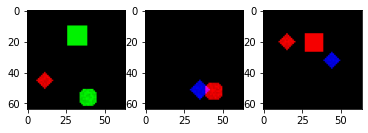

In [13]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets.sprites_base_dataset import SpritesBaseDataset
from datasets.sprites_meta_dataset import SpritesMetaDataset
domain_parser = Domain("mvcl/base.grammar")
meta_domain_str = f"""
(domain meta_demo)
(:type
    color - vector[float, 64]
    shape
)
(:predicate
    color ?x-object -> vector[float,100]
    shape ?x-object -> vector[float,100]

    red ?x-color -> boolean
    blue ?x-color -> boolean
    green ?x-color -> boolean

    square ?x-shape -> boolean
    circle ?x-shape -> boolean
    diamond ?x-shape -> boolean
)
(:derived
    is-good ?x-color expr: (??f ?x)
)
(:constraint
    (color: red blue green)
    (shape: square circle diamond)
)
"""
domain = load_domain_string(meta_domain_str, domain_parser)
batch_size = 3
base_dataset = SpritesBaseDataset("train")
base_loader = DataLoader(base_dataset, batch_size = batch_size, shuffle = True)

# [visualize the datsets, show some samples]
for sample in base_loader: sample;break;
fig = plt.figure("visualize data")
for b in range(batch_size):
    ax = fig.add_subplot(1,batch_size,b+1)
    ax.imshow(sample["img"][b].permute(1,2,0))


In [11]:
# [Create the Demo Model]
from rinarak.dklearn.nn.mlp import FCBlock
model = MetaVisualLearner(domain, config)


# [Pre-define some concept mapper]
color = Primitive.GLOBALS["color"]
color.value = lambda x: {**x, "features": x["model"].get_mapper("color")(x["features"])}
shape = Primitive.GLOBALS["shape"]
shape.value = lambda x: {**x, "features": x["model"].get_mapper("shape")(x["features"])}

model.perception.load_state_dict(torch.load("checkpoints/KFT_percept_backup.pth"))

import math
class ColorMapper(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.conv = nn.Conv2d(132,100,3,1,1)
    
    def forward(self, x):
        if len(x.shape) == 2:
            N, D = x.shape
            W, H = math.sqrt(N)
            x = x.reshape([1,W,H,D])
        if len(x.shape) == 3:
            B, N, D = x.shape
            W, H = math.sqrt(N)
            x = x.reshape(B,W,H,D)
        return self.conv(x).flatten(end_dim = -2)

color_mapper = ColorMapper(132,100)
shape_mapper = FCBlock(100,2,132,100)

model.implementations["color"] = color_mapper
model.implementations["shape"] = shape_mapper



In [56]:
#torch.save(model.perception.state_dict(), "checkpoints/convs_backbone.pth")

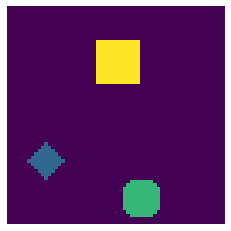

In [14]:
# [Take the Demo dataset sample as input]
ims = sample["img"]
masks = sample["masks"]

plt.figure("input-img")
plt.imshow(ims[0].permute(1,2,0))
plt.axis('off')
plt.savefig("outputs/input_image.png", bbox_inches='tight')
plt.cla()
plt.imshow(masks[0])
plt.axis('off')
plt.savefig("outputs/gt_masks.png", bbox_inches='tight')

outputs = model.perception(ims, masks.long().unsqueeze(1))
# save the results for the test run


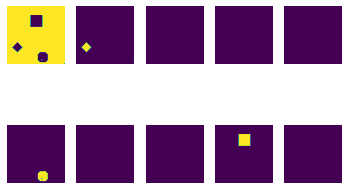

In [15]:
all_masks = outputs["masks"]
alives = outputs["alive"]
fig = plt.figure("masks"); b = 0
for i in range(all_masks.shape[-1]):
    ax = fig.add_subplot(2,5,1+i)
    plt.axis('off')
    ax.imshow(all_masks[b,:,:,i] * alives[b,i])

plt.savefig("outputs/predict_masks.png", bbox_inches='tight')

In [16]:
backbone_features = outputs["features"]
context = {
        "end":logit(alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
}
print(context["masks"].shape)

# there is an object has red shape
p = Program.parse(f"""
        (exists
            (intersect
                (exists
                    (Pr (color (expand (scene $0)) ) blue) 
                )
                (scene $0)
            )
        )
    """)

questions = sample["questions"]
programs = sample["programs"]
answers = sample["answers"]
numbers = [str(i) for i in range(0,10)]

#p = Program.parse("(expand (scene $0))")
loss = 0.0
for b in range(1):
    for program_idx in range(len(programs)):
        question = questions[program_idx][b]
        program = programs[program_idx][b]
        answer = answers[program_idx][b]
        p = Program.parse(program)
        output = p.evaluate({0:context})
        loss = 0.0
        if answer in ["yes", "no"]:
            if answer == "yes":
                loss += -torch.log(output["end"].sigmoid())
            if answer == "no":
                loss += -torch.log(1 - output["end"].sigmoid())
        if answer in numbers:
            loss += (output["end"]-1-int(answer))**2
        print(question)
        print("answer:{} gt-ans:{} loss:{}\n".format(output["end"].detach().numpy(),answer, loss.detach().numpy()))
loss /= (b+1) * (program_idx + 1)



torch.Size([10, 4096])


RuntimeError: Given groups=1, weight of size [100, 132, 3, 3], expected input[1, 10, 4096, 132] to have 132 channels, but got 10 channels instead

(
    intersect 
    (forall
        (union
            (Pr (color (expand (scene $0)) ) blue) 
            ( not (expand (scene $0)) )
        )
    )
    (scene $0)         
)

tensor([1.0000e-06, 4.3527e-01, 1.0000e-06, 3.9557e-01, 1.0000e-06, 1.0000e-06,
        4.0507e-01, 1.0000e-06, 1.0000e-06, 1.0000e-06])


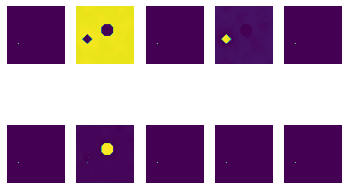

In [37]:
def display_reference(p, context):
    if isinstance(p, str): p = Program.parse(p)
    o = p.evaluate({0:context})
    masks = o["masks"].detach()
    ends = o["end"].detach()
    fig = plt.figure("ref-masks")

    for i in range(ends.shape[0]):
        ax = fig.add_subplot(2,5,1+i)
        plt.axis('off')
        ax.imshow(masks[i].reshape(64,64) * ends[i].sigmoid())
    print(ends.sigmoid().detach())


p1 = f"""(
    intersect 
    (forall
        (union
            (Pr (color (expand (scene $0)) ) {{}}) 
            ( not (expand (scene $0)) )
        )
    )
    (scene $0)         
)
"""
p2 = f"""(
    intersect 
    (exists
            (Pr (color (expand (scene $0)) ) {{}}) 
    )
    (scene $0)         
)
"""

outputs = model.perception(ims, masks.long().unsqueeze(1))
backbone_features = outputs["features"]
context = {
        "end":logit(alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
    }
print(p1.format("blue"))
display_reference(p1.format("blue"), context)


torch.Size([10, 4096])
shape:[10, 4096] max:0.9999990463256836 min:0.43056410551071167
shape:[4096] max:0.9999457597732544 min:0.5644305944442749
shape:[4096] max:0.9999990463256836 min:0.9999990463256836


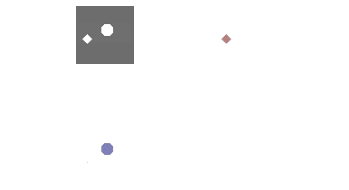

In [38]:
"""Test the Expand Operator Works"""    
p = f"""(
        (union
            (Pr (color(expand (scene $0)) )  green)
            (not(expand (scene $0)))
        )
)
"""

from rinarak.utils.tensor import stats_summary
if 1:
    p = Program.parse(p)
    o = p.evaluate({0:context})
    ends = o["end"].detach()
    fig = plt.figure("ref-masks")
    print(ends.shape)

    #print(ends.sigmoid())
    stats_summary(ends.sigmoid())
    for i in range(ends.shape[0]):
        ax = fig.add_subplot(2,5,1+i)
        plt.axis('off')
        ax.imshow(all_masks[b,:,:,i:i+1] * ims[b].permute(1,2,0)*ends[i].reshape([64,64,1]).sigmoid())
    
    stats_summary(ends[1].sigmoid())
    stats_summary(ends[5].sigmoid())



In [39]:
p = f"""(

    (forall
        (union
            (Pr (color(expand (scene $0)) )  red)
            (not(expand (scene $0)))
        )
    )

)
"""

from rinarak.utils.tensor import stats_summary
if 1:
    p = Program.parse(p)
    o = p.evaluate({0:context})
    ends = o["end"].detach()
    fig = plt.figure("ref-masks")
    print(ends.shape)

    print(ends.sigmoid().detach().float().numpy()) 


torch.Size([10])
[0.99999905 0.29527104 0.99999905 0.33039606 0.99999905 0.99999905
 0.34165448 0.99999905 0.99999905 0.99999905]


<Figure size 432x288 with 0 Axes>

In [42]:
import sys
for param in model.central_executor.parameters():
    param.requires_grad = True
for param in model.perception.parameters():
    param.requires_grad = False
optim = torch.optim.Adam(model.parameters(), lr = 2e-4)

outputs = model.perception(ims, masks.long().unsqueeze(1))
backbone_features = outputs["features"]

for epoch in range(4000):
    context = {
        "end":logit(alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
    }
    
    loss = 0.0
    u1 = 3
    u2 = 6

    o = Program.parse(p1.format("red")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u1]))
    o = Program.parse(p2.format("red")).evaluate({0:context})
    loss -= torch.log(1 - torch.sigmoid(o["end"][u2]))

    o = Program.parse(p1.format("blue")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u2]))
    o = Program.parse(p2.format("blue")).evaluate({0:context})
    loss -= torch.log(1 - torch.sigmoid(o["end"][u1]))

    optim.zero_grad()
    loss.backward()
    optim.step()
    vr=model.get_concept_embedding("green")
    vg=model.get_concept_embedding("blue")
    sys.stdout.write(f"\repoch:{epoch} loss:{loss} cos:{torch.cosine_similarity(vr,vg)}")

epoch:643 loss:2.772982597351074 cos:tensor([0.7929], grad_fn=<SumBackward1>))

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [65]:
vr=model.get_concept_embedding("green")
vg=model.get_concept_embedding("blue")
print(torch.cosine_similarity(vr,vg))

tensor([0.5443], grad_fn=<SumBackward1>)


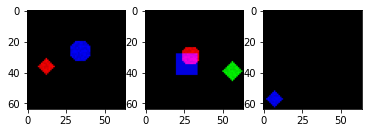

In [30]:
with open("outputs/logqa.txt","w") as log_file:
    for i in range(len(programs)):
        log_file.write("q:"+questions[i][0]+"\n")
        log_file.write("p:"+programs[i][0]+"\n")
        log_file.write("answer:"+answers[i][0]+"\n\n")
fig = plt.figure("visualize data")
for b in range(batch_size):
    ax = fig.add_subplot(1,batch_size,b+1)
    ax.imshow(sample["img"][b].permute(1,2,0))
        

red


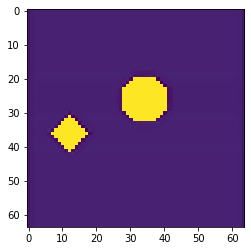

shape:[64, 64] max:0.0026279687881469727 min:-1.0413795709609985
green


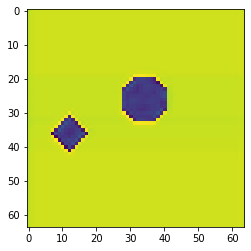

shape:[64, 64] max:0.17915546894073486 min:-0.30053794384002686
blue


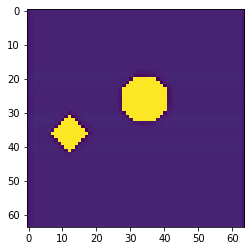

shape:[64, 64] max:-0.002148747444152832 min:-0.8809125423431396


In [41]:
from rinarak.utils.tensor import stats_summary
mapper = model.implementations["color"]
concept_feature_map = mapper(context["features"])
value_feature_maps = []
for value in ["red", "green", "blue"]:
    print(value)
    value_map = model.entailment(concept_feature_map, model.get_concept_embedding(value)).reshape([64,64])
    plt.imshow(value_map.sigmoid().detach())
    plt.show()
    stats_summary(value_map)

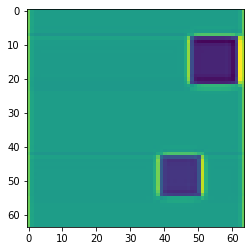

shape:[64, 64] max:-1.1431516408920288 min:-1.2043507099151611


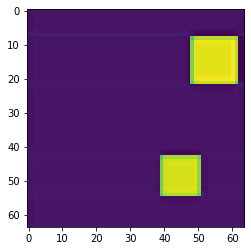

shape:[64, 64] max:-1.1230876445770264 min:-1.4070476293563843


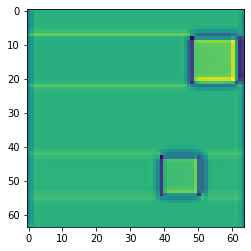

shape:[64, 64] max:-1.2420650720596313 min:-1.3049750328063965


In [50]:
mapper = model.implementations["shape"]
concept_feature_map = mapper(context["features"])
value_feature_maps = []
for value in ["square", "circle", "diamond"]:
    value_map = model.entailment(concept_feature_map, model.get_concept_embedding(value)).reshape([64,64])
    plt.imshow(value_map.sigmoid().detach())
    plt.show()
    stats_summary(value_map)